In [1]:
import pandas as pd
import seaborn as sns
from prophet import Prophet

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
data = pd.read_csv("../../data/od_15380_jml_pendapatan_asli_drh_bidang_pariwisata__sektor_wisa/data.jabarprov.go.id/disparbud-od_15380_jml_pendapatan_asli_drh_bidang_pariwisata__sektor_wisa_data.csv")
data.head(5)

,id,kode_provinsi,nama_provinsi,kode_kabupaten_kota,nama_kabupaten_kota,sektor_wisata,jumlah_pendapatan,satuan,tahun
0,1,32,JAWA BARAT,3201,KABUPATEN BOGOR,HOTEL,0,RUPIAH,2014
1,2,32,JAWA BARAT,3201,KABUPATEN BOGOR,RESTORAN/RUMAH MAKAN,27946638075,RUPIAH,2014
2,3,32,JAWA BARAT,3201,KABUPATEN BOGOR,HIBURAN,7077430815,RUPIAH,2014
3,4,32,JAWA BARAT,3201,KABUPATEN BOGOR,RETRIBUSI,485255100,RUPIAH,2014
4,5,32,JAWA BARAT,3202,KABUPATEN SUKABUMI,HOTEL,0,RUPIAH,2014


In [51]:
KOTA = "KABUPATEN SUKABUMI"
data_specialize = data.copy()
data_specialize = data_specialize[data_specialize["nama_kabupaten_kota"] == KOTA]

hotel_pendapatan = pd.DataFrame()
hotel_pendapatan["tahun"] = data_specialize["tahun"].unique()
hotel_pendapatan["jumlah_pendapatan"] = data_specialize[data_specialize["sektor_wisata"]
                                                        == "HOTEL"].reset_index()["jumlah_pendapatan"]
hotel_pendapatan = hotel_pendapatan.reset_index().rename(
    columns={"tahun": "ds", "jumlah_pendapatan": "y"}).drop(columns="index")

rm_pendapatan = pd.DataFrame()
rm_pendapatan["tahun"] = data_specialize["tahun"].unique()
rm_pendapatan["jumlah_pendapatan"] = data_specialize[data_specialize["sektor_wisata"]
                                                        == "RESTORAN/RUMAH MAKAN"].reset_index()["jumlah_pendapatan"]
rm_pendapatan = rm_pendapatan.reset_index().rename(
    columns={"tahun": "ds", "jumlah_pendapatan": "y"}).drop(columns="index")

hiburan_pendapatan = pd.DataFrame()
hiburan_pendapatan["tahun"] = data_specialize["tahun"].unique()
hiburan_pendapatan["jumlah_pendapatan"] = data_specialize[data_specialize["sektor_wisata"]
                                                        == "HIBURAN"].reset_index()["jumlah_pendapatan"]
hiburan_pendapatan = hiburan_pendapatan.reset_index().rename(
    columns={"tahun": "ds", "jumlah_pendapatan": "y"}).drop(columns="index")

hiburan_pendapatan


,ds,y
0,2014,0
1,2015,0
2,2016,0
3,2017,0
4,2018,0
5,2019,155879163
6,2020,214672788


<AxesSubplot:xlabel='ds'>

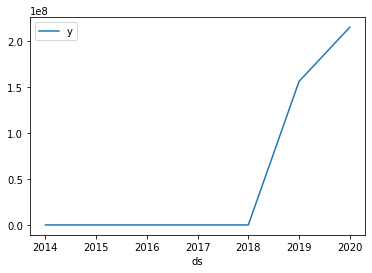

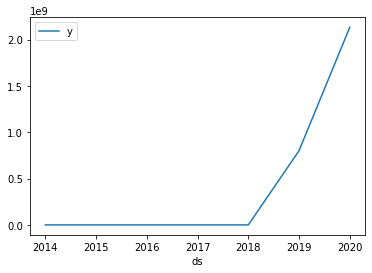

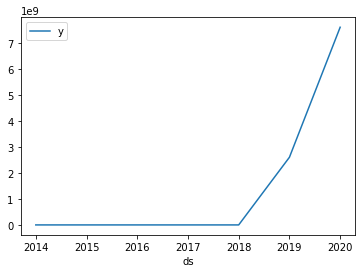

In [52]:
hiburan_pendapatan.set_index("ds").plot()
hotel_pendapatan.set_index("ds").plot()
rm_pendapatan.set_index("ds").plot()

In [53]:
hiburan_model = Prophet(seasonality_mode="multiplicative")
hiburan_model.fit(hiburan_pendapatan)

hotel_model = Prophet(seasonality_mode="multiplicative")
hotel_model.fit(hotel_pendapatan)

rm_model = Prophet(seasonality_mode="multiplicative")
rm_model.fit(rm_pendapatan)


INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing


In [54]:
hiburan_future = pd.DataFrame({
    "ds": [max(hiburan_pendapatan["ds"]) + i for i in range(1, 6)]
})
hiburan_future["y"] = hiburan_model.predict(hiburan_future)["yhat"]
hiburan_gabung = pd.concat([hiburan_pendapatan, hiburan_future])
hiburan_gabung = hiburan_gabung.rename(columns={"ds":"tahun", "y": "pendapatan"})

hotel_future = pd.DataFrame({
    "ds": [max(hotel_pendapatan["ds"]) + i for i in range(1, 6)]
})
hotel_future["y"] = hotel_model.predict(hotel_future)["yhat"]
hotel_gabung = pd.concat([hotel_pendapatan, hotel_future])
hotel_gabung = hotel_gabung.rename(columns={"ds":"tahun", "y": "pendapatan"})

rm_future = pd.DataFrame({
    "ds": [max(rm_pendapatan["ds"]) + i for i in range(1, 6)]
})
rm_future["y"] = rm_model.predict(rm_future)["yhat"]
rm_gabung = pd.concat([rm_pendapatan, rm_future])
rm_gabung = rm_gabung.rename(columns={"ds":"tahun", "y": "pendapatan"})

<AxesSubplot:xlabel='tahun'>

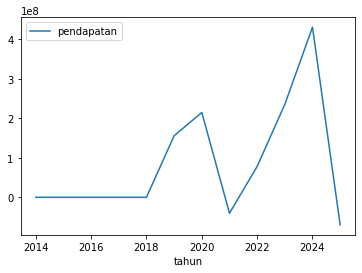

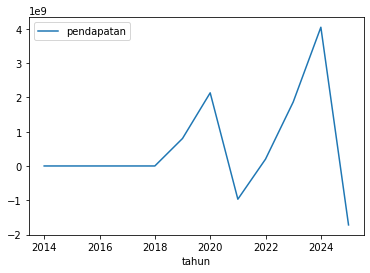

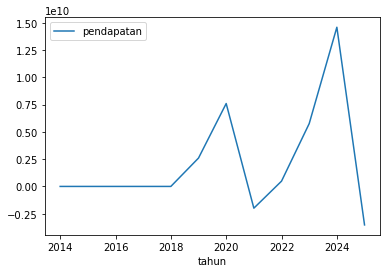

In [55]:
hiburan_gabung.plot(x="tahun", y="pendapatan", kind="line")
hotel_gabung.plot(x="tahun", y="pendapatan", kind="line")
rm_gabung.plot(x="tahun", y="pendapatan", kind="line")

In [56]:
from sklearn.metrics import mean_squared_error
import numpy as np

# evaluate forecasts
hiburan_pendapatan["yhat"] = hiburan_model.predict(hiburan_pendapatan)["yhat"]
rm_pendapatan["yhat"] = rm_model.predict(rm_pendapatan)["yhat"]
hotel_pendapatan["yhat"] = hotel_model.predict(hotel_pendapatan)["yhat"]

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true=y_true, y_pred=y_pred))

print(f"RMSE Hiburan        : {rmse(hiburan_pendapatan['y'], hiburan_pendapatan['yhat'])}")
print(f"RMSE Rumah Makan    : {rmse(rm_pendapatan['y'], rm_pendapatan['yhat'])}")
print(f"RMSE Hotel          : {rmse(hotel_pendapatan['y'], hotel_pendapatan['yhat'])}")

RMSE Hiburan        : 25421586.495177727
RMSE Rumah Makan    : 340925820.34937304
RMSE Hotel          : 128408621.20753287


<AxesSubplot:>

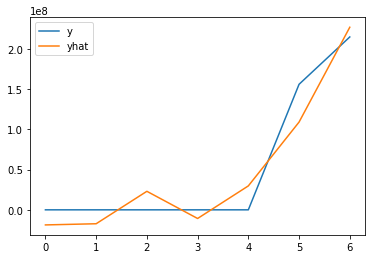

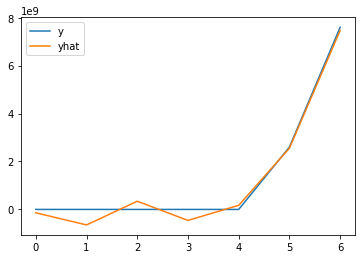

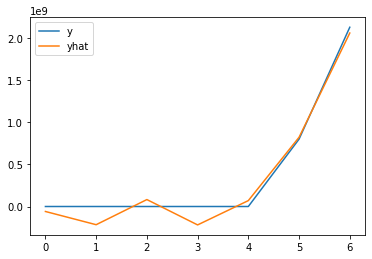

In [57]:
hiburan_pendapatan[["y", "yhat"]].plot()
rm_pendapatan[["y", "yhat"]].plot()
hotel_pendapatan[["y", "yhat"]].plot()

In [ ]:
def forecast_pendapatan(KOTA: str) -> tuple(pd.DataFrame, pd.DataFrame, pd.DataFrame):
    data_specialize = data.copy()
    data_specialize = data_specialize[data_specialize["nama_kabupaten_kota"] == KOTA]

    hotel_pendapatan = pd.DataFrame()
    hotel_pendapatan["tahun"] = data_specialize["tahun"].unique()
    hotel_pendapatan["jumlah_pendapatan"] = data_specialize[data_specialize["sektor_wisata"]
                                                            == "HOTEL"].reset_index()["jumlah_pendapatan"]
    hotel_pendapatan = hotel_pendapatan.reset_index().rename(
        columns={"tahun": "ds", "jumlah_pendapatan": "y"}).drop(columns="index")

    rm_pendapatan = pd.DataFrame()
    rm_pendapatan["tahun"] = data_specialize["tahun"].unique()
    rm_pendapatan["jumlah_pendapatan"] = data_specialize[data_specialize["sektor_wisata"]
                                                            == "RESTORAN/RUMAH MAKAN"].reset_index()["jumlah_pendapatan"]
    rm_pendapatan = rm_pendapatan.reset_index().rename(
        columns={"tahun": "ds", "jumlah_pendapatan": "y"}).drop(columns="index")

    hiburan_pendapatan = pd.DataFrame()
    hiburan_pendapatan["tahun"] = data_specialize["tahun"].unique()
    hiburan_pendapatan["jumlah_pendapatan"] = data_specialize[data_specialize["sektor_wisata"]
                                                            == "HIBURAN"].reset_index()["jumlah_pendapatan"]
    hiburan_pendapatan = hiburan_pendapatan.reset_index().rename(
        columns={"tahun": "ds", "jumlah_pendapatan": "y"}).drop(columns="index")

    # Training
    hiburan_model = Prophet()
    hiburan_model.fit(hiburan_pendapatan)

    hotel_model = Prophet()
    hotel_model.fit(hotel_pendapatan)

    rm_model = Prophet()
    rm_model.fit(rm_pendapatan)

    # Forecasting
    hiburan_future = pd.DataFrame({
        "ds": [max(hiburan_pendapatan["ds"]) + i for i in range(1, 6)]
    })
    hiburan_future["y"] = hiburan_model.predict(hiburan_future)["yhat"]
    hiburan_gabung = pd.concat([hiburan_pendapatan, hiburan_future])
    hiburan_gabung = hiburan_gabung.rename(
        columns={"ds": "tahun", "y": "pendapatan"})

    hotel_future = pd.DataFrame({
        "ds": [max(hotel_pendapatan["ds"]) + i for i in range(1, 6)]
    })
    hotel_future["y"] = hotel_model.predict(hotel_future)["yhat"]
    hotel_gabung = pd.concat([hotel_pendapatan, hotel_future])
    hotel_gabung = hotel_gabung.rename(columns={"ds": "tahun", "y": "pendapatan"})

    rm_future = pd.DataFrame({
        "ds": [max(rm_pendapatan["ds"]) + i for i in range(1, 6)]
    })
    rm_future["y"] = rm_model.predict(rm_future)["yhat"]
    rm_gabung = pd.concat([rm_pendapatan, rm_future])
    rm_gabung = rm_gabung.rename(columns={"ds": "tahun", "y": "pendapatan"})

    return hiburan_gabung, hotel_gabung, rm_gabung